In [28]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score
import time
import torchvision
import torchvision.transforms as transforms
import matplotlib.cm as cm
import matplotlib as mpl
import copy
from sklearn.utils.class_weight import compute_class_weight
import statsmodels.formula.api as sm

import sys 
sys.path.append('../src/')
from DVGS import DVGS
from utils import get_corruption_scores
from NN import NN
from utils import load_data 
import similarities

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
train_num_options = np.linspace(500, 30000, 10, dtype=int)
T_options = [1,2,5]

In [40]:
def run(train_num, T): 
    
    model = NN(in_channels      = 108, 
            out_channels     = 2, 
            num_layers       = 2, 
            hidden_channels  = 100, 
            norm             = True, 
            dropout          = 0.5, 
            bias             = True, 
            act              = torch.nn.Mish, 
            out_fn           = None)
    
    x_train, y_train, x_valid, y_valid, x_test, y_test, exog_noise, endog_noise, kwargs = load_data(dataset     = 'adult', 
                                                                                                    train_num   = train_num, 
                                                                                                    valid_num   = 400, 
                                                                                                    exog_noise  = 0., 
                                                                                                    endog_noise = 0.2, 
                                                                                                    save_dir    = f'../temp-data/', 
                                                                                                    clean_up    = True,
                                                                                                    transforms  = None)
    
    classes = list(np.sort(np.unique(y_train.detach().numpy())).astype(int))

    dvgs = DVGS(x_source         = x_train,
                y_source         = y_train, 
                x_target         = x_valid,  
                y_target         = y_valid, 
                model            = copy.deepcopy(model))

    if True:
        class_weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=classes, y=y_valid.detach().numpy().ravel()), dtype=torch.float).to('cuda')
    else: 
        class_weights = None # torch.tensor([0.5, 1.]).to('cuda')

    CEL = torch.nn.CrossEntropyLoss(weight=class_weights) 

    tic = time.time() 

    run_id = dvgs.run(target_crit               = lambda x,y: CEL(x,y.squeeze(1)), 
                    source_crit               = lambda x,y: torch.nn.functional.cross_entropy(x, y.squeeze(1)),
                    num_restarts              = 1,
                    save_dir                  = '../results/',
                    similarity                = similarities.cosine_similarity(),
                    optim                     = torch.optim.Adam, 
                    lr                        = 1e-3,
                    num_epochs                = 100, 
                    compute_every             = T, 
                    source_batch_size         = 500, 
                    target_batch_size         = 400,
                    grad_params               = None, 
                    verbose                   = False, 
                    use_cuda                  = True)

    vals_dvgs = dvgs.agg(f'../results/{run_id}/')
    dvgs.clean(f'../results/{run_id}/')
    elapsed = time.time() - tic
    auroc = roc_auc_score(endog_noise, -vals_dvgs)

    print(train_num, T, elapsed, auroc)

    return auroc, elapsed

In [41]:
res = {'train_num':[],
       'T':[], 
       'elapsed':[],
       'auroc':[]} 


for train_num in train_num_options: 
    for T in T_options: 
        res['train_num'].append(train_num)
        res['T'].append(T)
        auroc, elapsed = run(train_num, T)
        res['elapsed'].append(elapsed)
        res['auroc'].append(auroc)
                                
res = pd.DataFrame(res)
res.head()

500 1 1.5385794639587402 0.8753000000000001
500 2 0.9251189231872559 0.8385499999999999
500 5 0.6951119899749756 0.890475
5444 1 7.364964485168457 0.8814322410265759
5444 2 3.813657760620117 0.891992071449792
5444 5 1.9264438152313232 0.8803743906309079
10388 1 13.49557113647461 0.8941245156180818
10388 2 6.657733678817749 0.8679053990838925
10388 5 3.0373826026916504 0.8500209738797134
15333 1 18.964146852493286 0.886820470557493
15333 2 10.035286903381348 0.8862118260102159
15333 5 4.578825235366821 0.8400585877042928
20277 1 27.077512502670288 0.8860994818958469
20277 2 12.533743858337402 0.8717223918865568
20277 5 5.379899024963379 0.8410730826186172
25222 1 30.158173322677612 0.8343015795423899
25222 2 15.5458242893219 0.8827762955296592
25222 5 7.037868976593018 0.8713035074278257
30166 1 39.79842519760132 0.8706705929443477
30166 2 19.521955966949463 0.8421610705066389
30166 5 7.571671485900879 0.8124067954294585
35111 1 38.55855131149292 0.8959090093202728
35111 2 20.2828409671

,train_num,T,elapsed,auroc
0,500,1,1.538579,0.875300
1,500,2,0.925119,0.838550
2,500,5,0.695112,0.890475
3,5444,1,7.364964,0.881432
4,5444,2,3.813658,0.891992


In [42]:
result = sm.ols(formula="elapsed ~ train_num", data=res[lambda x: x['T'] == 1]).fit()
result.summary()

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                elapsed   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     91.08
Date:                Fri, 10 Mar 2023   Prob (F-statistic):           1.20e-05
Time:                        14:56:36   Log-Likelihood:                -27.741
No. Observations:                  10   AIC:                             59.48
Df Residuals:                       8   BIC:                             60.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.5690      2.589      1.765      0.116      -1.401      10.539
train_num      0.0009   9.65e-05      9.544      0.000       0.001       0.001
==============================================================================
Omnibus:                        0.270   Durbin-Watson:                   0.785
Prob(Omnibus):                  0.874   Jarque-Bera (JB):                0.070
Skew:                           0.116   Prob(JB):                        0.966
Kurtosis:                       2.662   Cond. No.                     5.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
res = res.assign(train_num_k=lambda x: x.train_num / 1000)
res = res[lambda x: x.train_num <= 30000]
res = res.assign(Tc = lambda x: [str(t) for t in x['T']])

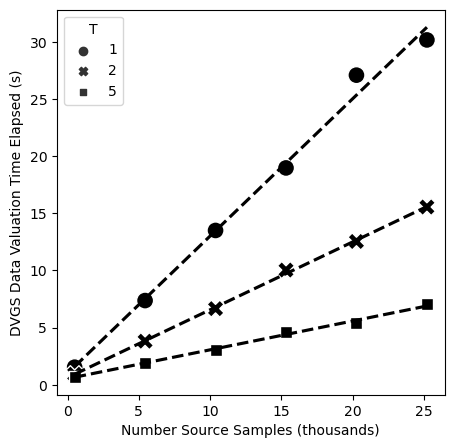

In [80]:
plt.figure(figsize=(5,5))
sbn.scatterplot(x='train_num_k', y='elapsed', data=res, style='T', c='k', s=150)
sbn.regplot(x='train_num_k', y='elapsed', data=res[lambda x: x['T'] == 1], ci=None, scatter=None, color='k', line_kws={'linestyle':'--'})
sbn.regplot(x='train_num_k', y='elapsed', data=res[lambda x: x['T'] == 2], ci=None, scatter=None, color='k', line_kws={'linestyle':'--'})
sbn.regplot(x='train_num_k', y='elapsed', data=res[lambda x: x['T'] == 5], ci=None, scatter=None, color = 'k', line_kws={'linestyle':'--'})
plt.xlabel('Number Source Samples (thousands)')
plt.ylabel('DVGS Data Valuation Time Elapsed (s)')
plt.savefig('../results/scalability_time.png')
plt.show()

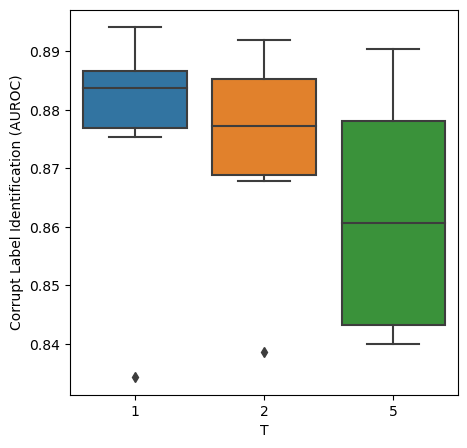

In [79]:
plt.figure(figsize=(5,5))
sbn.boxplot(x='T', y='auroc', data=res)
plt.ylabel('Corrupt Label Identification (AUROC)')
plt.savefig('../results/scalability_T_perf.png', dpi=300)
plt.show()